In [1]:
# Clone your GitHub repo (you’ll be prompted to authorize if it's private)
!git clone https://github.com/colterwood/LHL-final-final-project.git

Cloning into 'LHL-final-final-project'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 187 (delta 98), reused 25 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (187/187), 1.56 MiB | 1.44 MiB/s, done.
Resolving deltas: 100% (98/98), done.


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from google.colab import files
import matplotlib.pyplot as plt

In [3]:
# load the player game logs CSV from the data folder
df = pd.read_csv("LHL-final-final-project/data/wnba_model_ready_with_top_off_def_players_v1.csv")


# preview
df.head()

,advanced_3par,advanced_ast_pct,advanced_blk_pct,advanced_drtg,advanced_ftr,advanced_ortg,advanced_pace,advanced_pace_by_team_day_of_week,advanced_stl_pct,advanced_trb_pct,...,Rickea Jackson,Sabrina Ionescu,Satou Sabally,Shatori Walker-Kimbrough,Skylar Diggins-Smith,Sophie Cunningham,Stefanie Dolson,Teaira McCowan,Temi Fagbenle,Tina Charles
0,0.254,58.8,22.0,100.4,0.284,114.0,80.7,79.4,9.9,49.3,...,0,0,0,0,0,0,0,0,0,1
1,0.348,77.8,11.6,107.3,0.409,103.6,82.0,80.2,9.8,46.5,...,0,0,0,0,0,0,0,0,0,1
2,0.306,56.7,5.6,100.5,0.306,107.0,77.6,74.8,11.6,50.7,...,0,0,0,0,0,0,0,0,0,1
3,0.324,74.2,3.0,124.6,0.206,107.0,73.8,76.1,12.2,50.8,...,0,0,0,0,0,0,0,0,0,1
4,0.339,73.1,4.3,84.4,0.339,92.0,79.4,79.4,11.3,53.7,...,0,0,0,0,0,0,0,0,0,1


In [4]:
df.shape

(480, 90)

In [5]:
for col in df.columns:
  print(col)

advanced_3par
advanced_ast_pct
advanced_blk_pct
advanced_drtg
advanced_ftr
advanced_ortg
advanced_pace
advanced_pace_by_team_day_of_week
advanced_stl_pct
advanced_trb_pct
advanced_ts_pct
day
defensive_four_factors_drb_pct
defensive_four_factors_efg_pct
defensive_four_factors_ft_per_fga
defensive_four_factors_tov_pct
month
month_by_team_day_of_week
offensive_four_factors_orb_pct
offensive_four_factors_tov_pct
opponent_3p_pct
opponent_fg_pct
opponent_ft_pct
team_3p_pct
team_day_median_allowed
team_ft_pct
team_vs_opp_homeaway_median_score
team_vs_opp_median_score
win_loss
team
opp
team_score
opp_score
A'ja Wilson
Aaliyah Edwards
Aari McDonald
Alanna Smith
Aliyah Boston
Allisha Gray
Alysha Clark
Alyssa Thomas
Angel Reese
Ariel Atkins
Arike Ogunbowale
Azura Stevens
Breanna Stewart
Bridget Carleton
Brionna Jones
Brittney Griner
Caitlin Clark
Cameron Brink
Chelsea Gray
Chennedy Carter
Cheyenne Parker-Tyus
DeWanna Bonner
Dearica Hamby
Diana Taurasi
Elizabeth Williams
Ezi Magbegor
Jackie Young


In [12]:
df = df.drop(columns=['win_loss'])

In [13]:
# save as CSV
df.to_csv("wnba_model_ready_with_top_off_def_players_v1.csv", index=False)

# download to local machine
from google.colab import files
files.download("wnba_model_ready_with_top_off_def_players_v1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# targets
target_cols = ["team_score", "opp_score"]

# models to train: 12 teams + league-wide
teams = df["team"].unique().tolist() + ["League"]

# store overall results summary
results = []

# store row-level predictions
all_predictions = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features: drop non-feature columns
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # track team + opp info from original df
    meta = df_team.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

    # model
    model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # compute row-level absolute errors
    team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
    opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

    # build prediction rows
    for i in range(len(meta)):
        all_predictions.append({
            "Model": team_name,
            "team": meta.loc[i, "team"],
            "opp": meta.loc[i, "opp"],
            "team_score": meta.loc[i, "team_score"],
            "team_score_pred": y_pred[i, 0],
            "team_score_mae": team_score_mae[i],
            "opp_score": meta.loc[i, "opp_score"],
            "opp_score_pred": y_pred[i, 1],
            "opp_score_mae": opp_score_mae[i],
        })

    # overall summary metrics
    for i, col in enumerate(target_cols):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        results.append({
            "Model": team_name,
            "Target": col,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

# create final prediction DataFrame
predictions_df = pd.DataFrame(all_predictions)

# preview
predictions_df.head()

,Model,team,opp,team_score,team_score_pred,team_score_mae,opp_score,opp_score_pred,opp_score_mae
0,ATL,ATL,CON,67,81.36,14.36,80,88.72,8.72
1,ATL,ATL,NYL,75,79.82,4.82,81,85.43,4.43
2,ATL,ATL,CON,78,83.40,5.40,74,74.03,0.03
3,ATL,ATL,PHO,72,70.79,1.21,63,69.92,6.92
4,ATL,ATL,WAS,73,79.41,6.41,67,73.35,6.35


In [15]:
mae_summary = (
    predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# optional: flatten column names
mae_summary.columns = ['_'.join(col).strip('_') for col in mae_summary.columns]

mae_summary

,Model,team_score_mae_min,team_score_mae_max,team_score_mae_mean,team_score_mae_median,opp_score_mae_min,opp_score_mae_max,opp_score_mae_mean,opp_score_mae_median
0,ATL,1.21,14.36,6.300000,5.110,0.03,8.72,4.998750,5.255
1,CHI,1.69,5.84,3.455000,2.810,0.73,7.30,2.876250,2.665
2,CON,0.65,8.62,4.337500,4.175,0.14,8.87,3.227500,2.320
3,DAL,0.24,3.42,1.623750,1.585,0.19,5.77,2.183750,1.000
4,IND,0.73,8.38,2.593750,1.860,0.52,9.37,3.326250,2.850
5,LAS,0.41,7.49,3.598750,3.305,0.71,5.85,2.348750,2.195
6,LVA,0.73,8.63,3.820000,3.280,1.82,10.60,5.212500,4.930
7,League,0.02,20.06,2.099479,1.265,0.01,19.79,1.832292,0.995
8,MIN,0.72,10.50,4.701250,4.075,1.24,10.40,3.370000,2.660
9,NYL,0.22,4.41,1.098750,0.615,0.32,5.30,2.068750,1.785


In [20]:
# store importances for all models
all_importances = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # model
    model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
    model.fit(X_train, y_train)

    # get feature importances from both estimators
    team_score_importance = model.estimators_[0].feature_importances_
    opp_score_importance = model.estimators_[1].feature_importances_

    # stack into rows
    for i, feature in enumerate(X.columns):
        all_importances.append({
            "Model": team_name,
            "Feature": feature,
            "Target": "team_score",
            "Importance": team_score_importance[i]
        })
        all_importances.append({
            "Model": team_name,
            "Feature": feature,
            "Target": "opp_score",
            "Importance": opp_score_importance[i]
        })

# build final DataFrame
importances_df = pd.DataFrame(all_importances)

# optional: sort by importance descending
importances_df = importances_df.sort_values(by="Importance", ascending=True)

importances_df.head(20)

,Model,Feature,Target,Importance
1684,PHO,Satou Sabally,team_score,0.0
1674,PHO,Odyssey Sims,team_score,0.0
1675,PHO,Odyssey Sims,opp_score,0.0
1678,PHO,Rhyne Howard,team_score,0.0
1679,PHO,Rhyne Howard,opp_score,0.0
1697,PHO,Temi Fagbenle,opp_score,0.0
1698,PHO,Tina Charles,team_score,0.0
1699,PHO,Tina Charles,opp_score,0.0
1681,PHO,Rickea Jackson,opp_score,0.0
1682,PHO,Sabrina Ionescu,team_score,0.0


In [17]:
# sort by importance descending
importances_df = importances_df.sort_values(by="Importance", ascending=False)

importances_df.head(20)

,Model,Feature,Target,Importance
2047,League,advanced_drtg,opp_score,0.839000
1027,LVA,advanced_drtg,opp_score,0.822682
2050,League,advanced_ortg,team_score,0.790627
1880,WAS,advanced_ortg,team_score,0.784005
1367,NYL,advanced_drtg,opp_score,0.754395
177,CHI,advanced_drtg,opp_score,0.712524
687,IND,advanced_drtg,opp_score,0.701265
1877,WAS,advanced_drtg,opp_score,0.689660
860,LAS,advanced_ortg,team_score,0.687872
350,CON,advanced_ortg,team_score,0.665959


<ipython-input-18-7fd42919fbe4>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.sort_values('Importance', ascending=False).head(10))


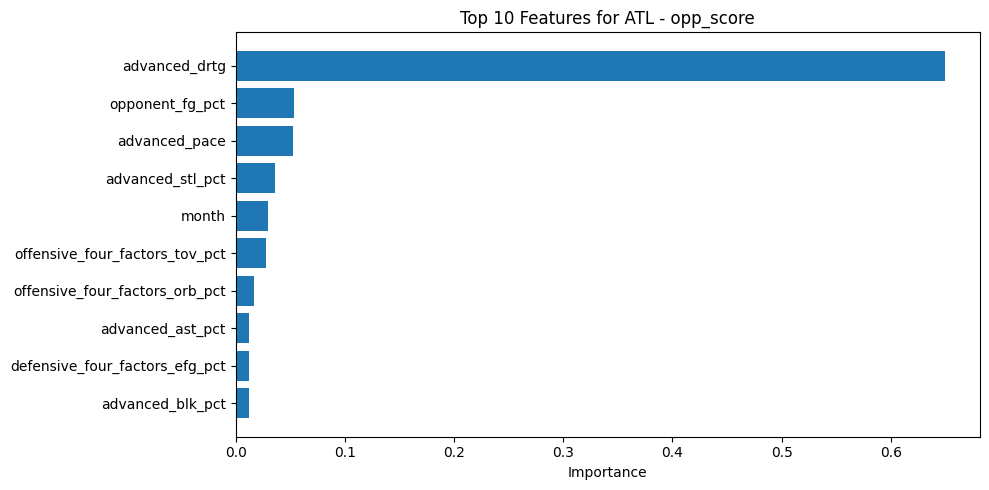

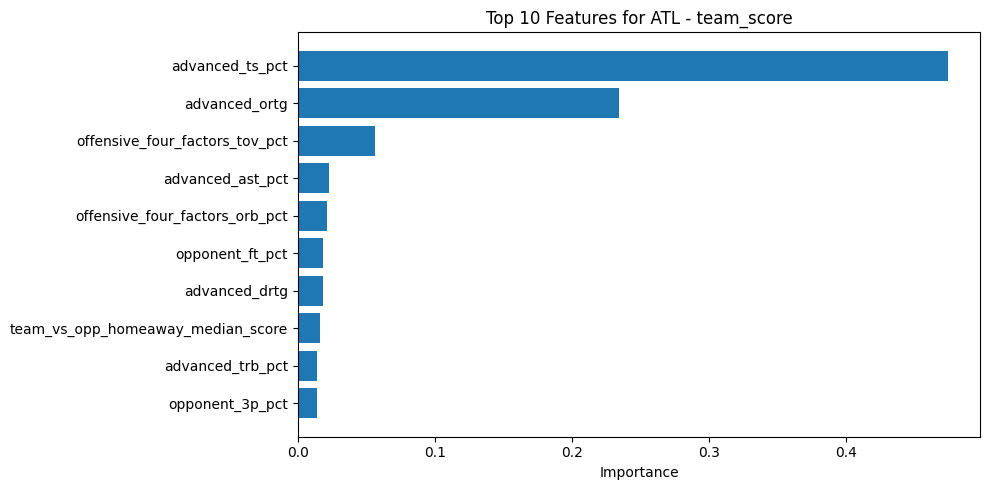

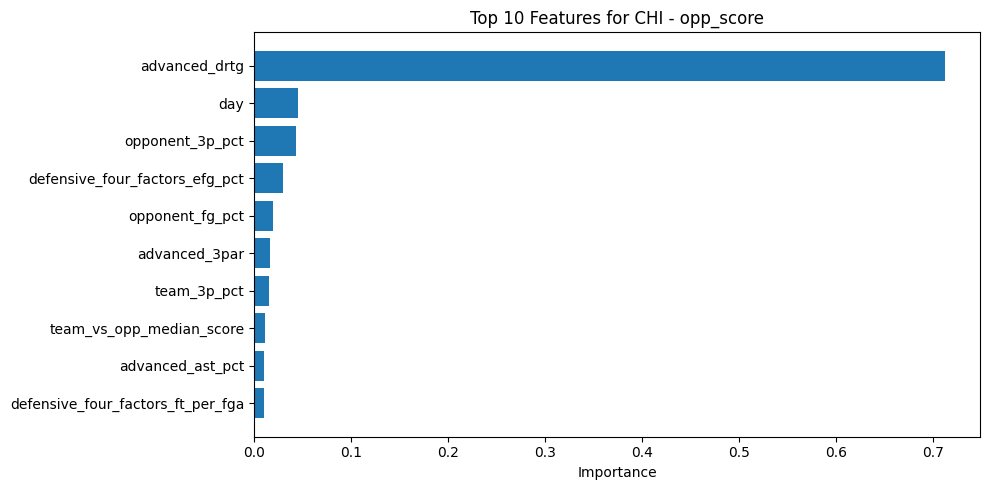

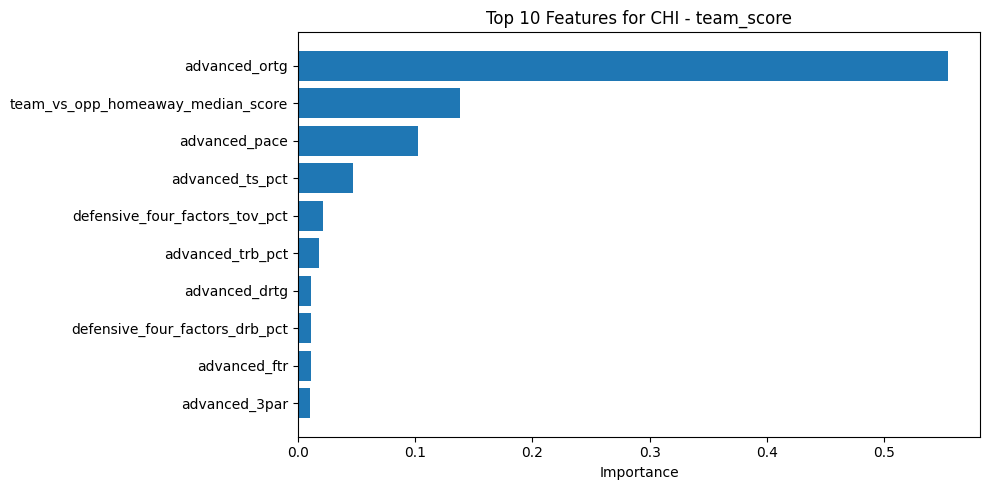

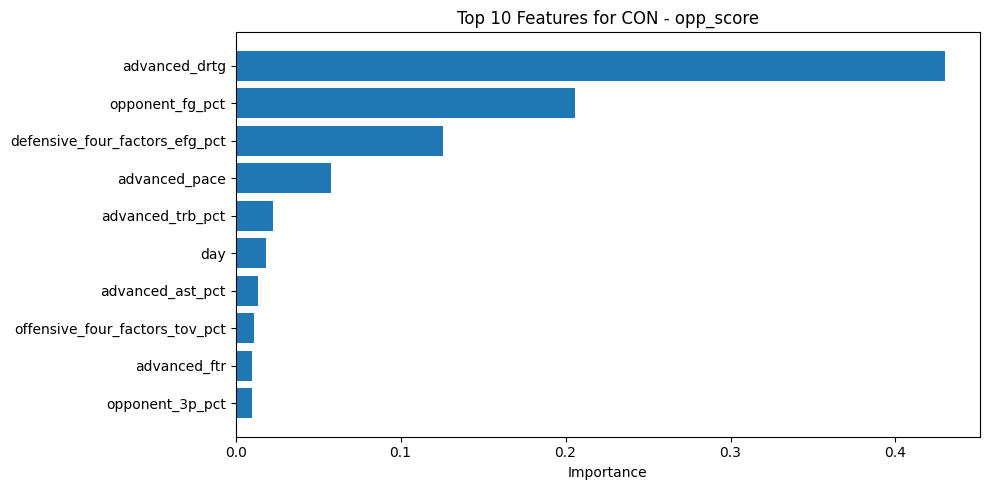

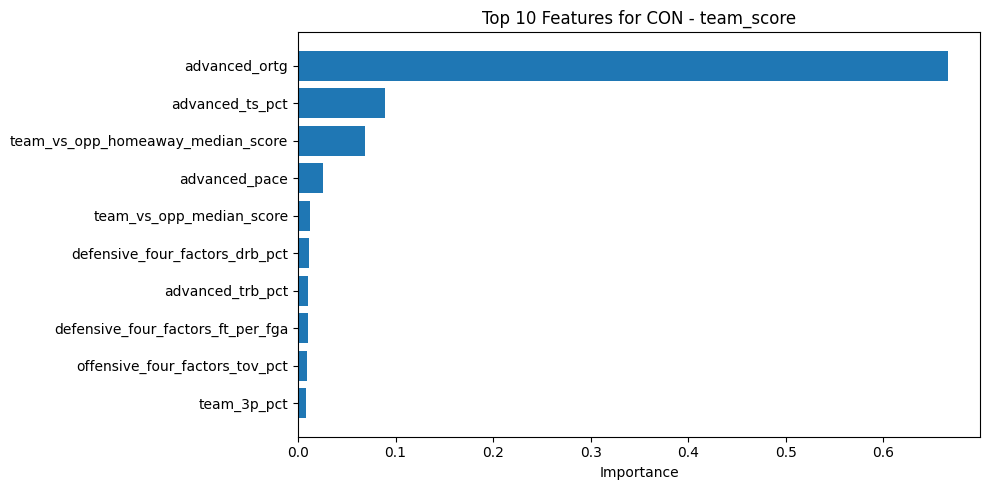

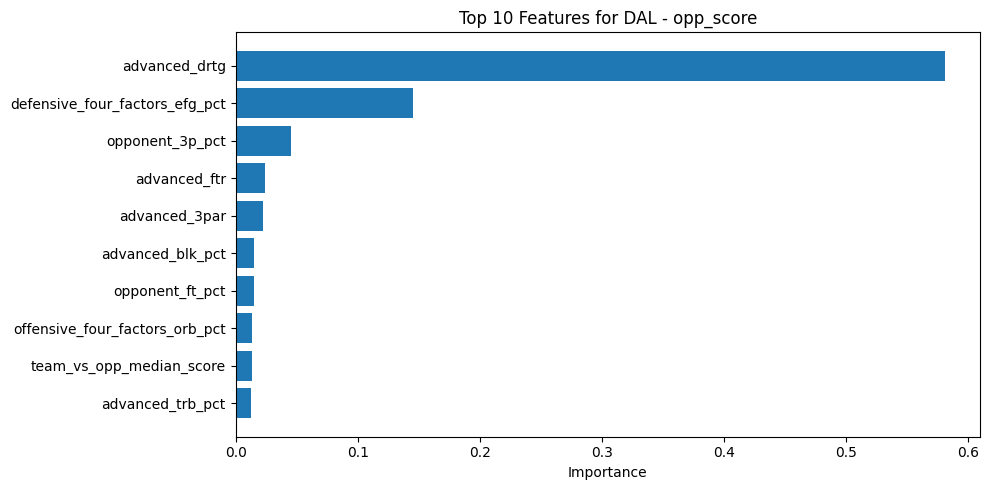

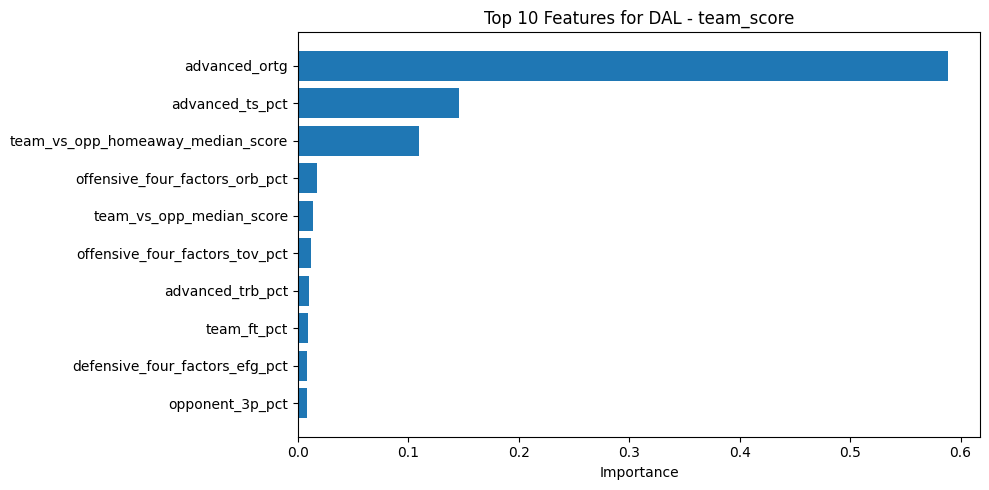

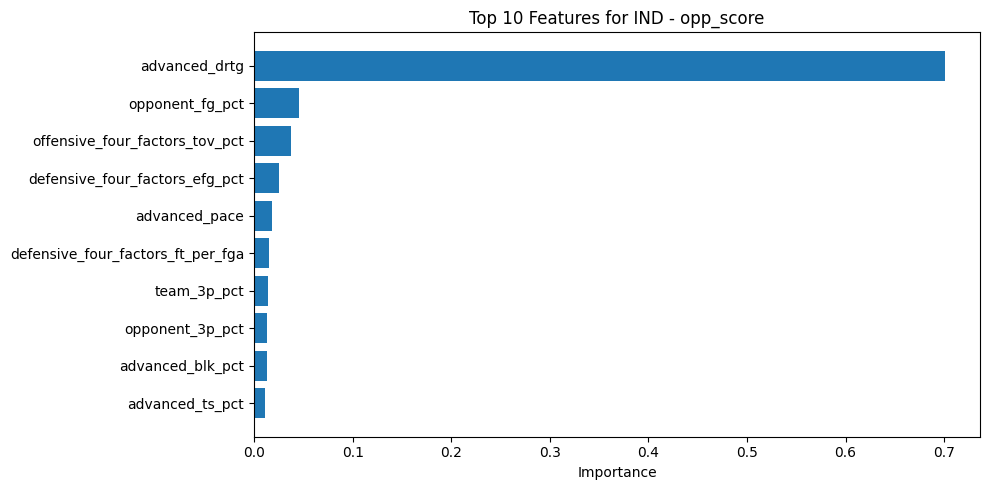

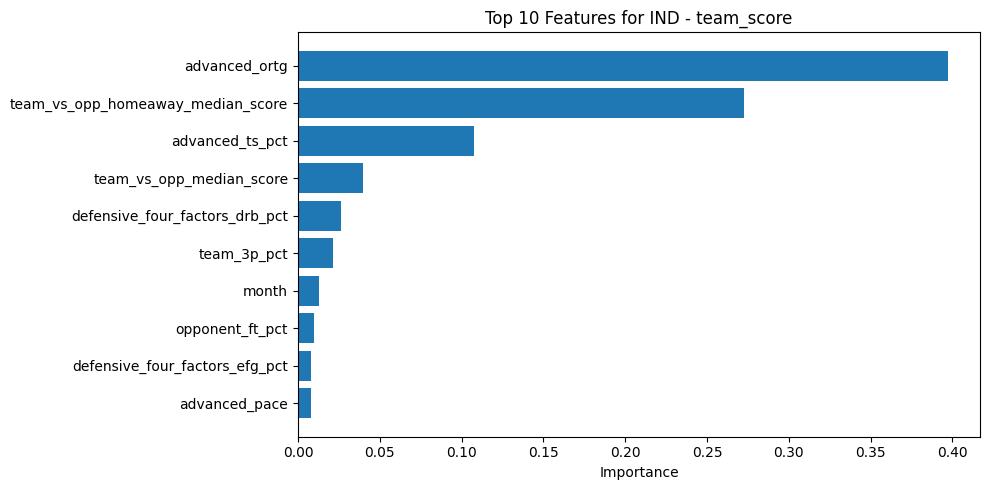

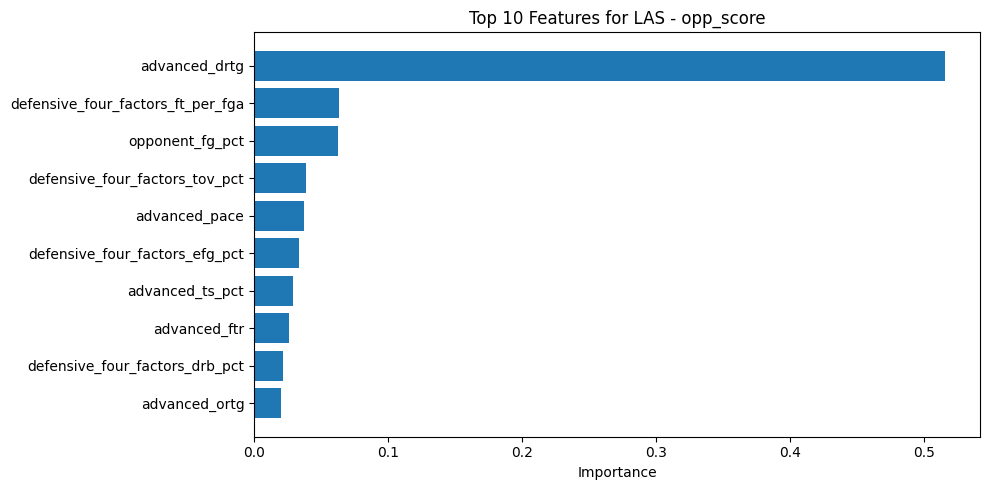

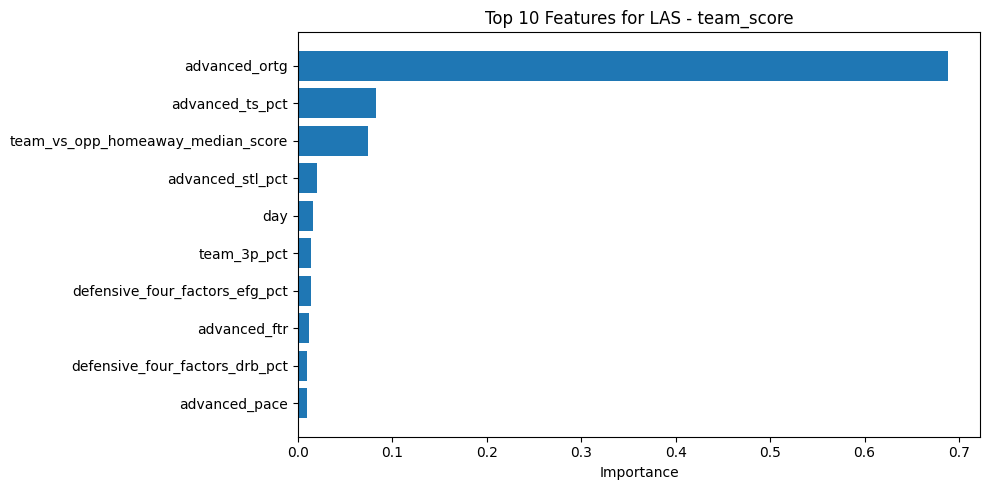

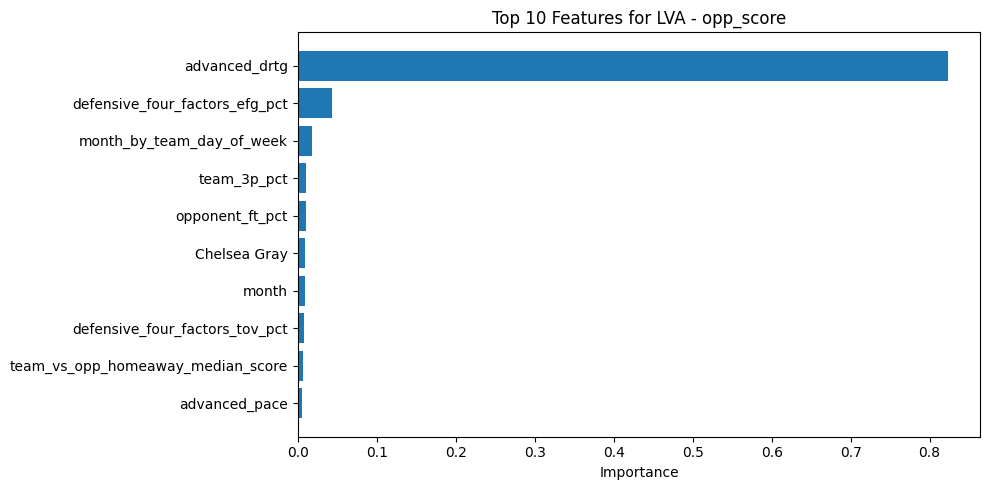

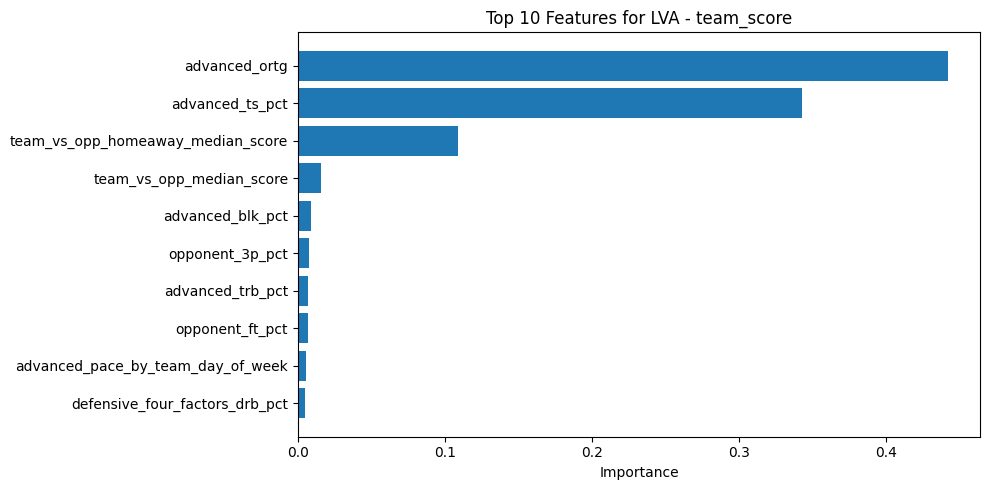

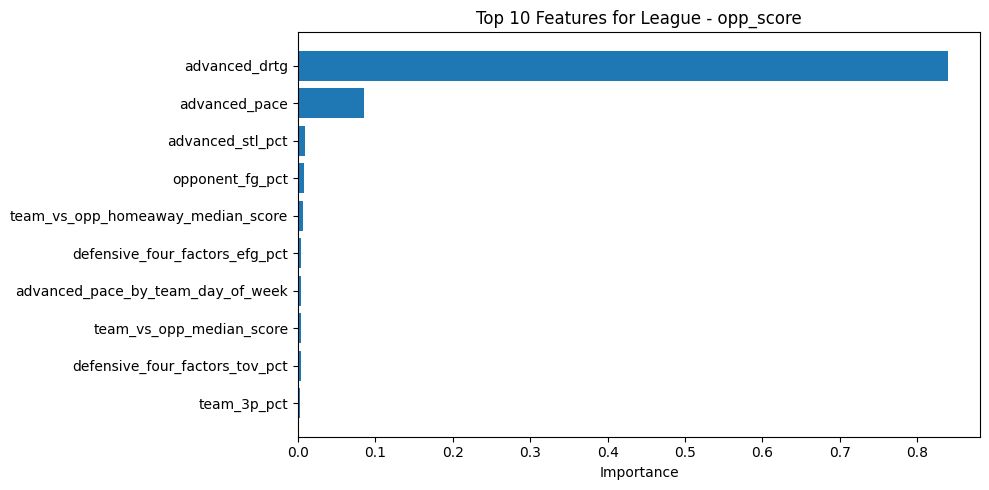

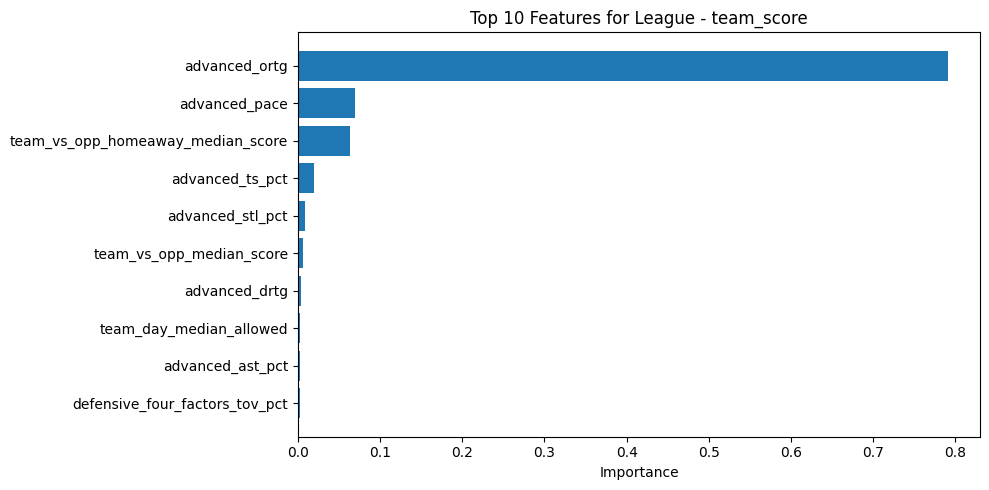

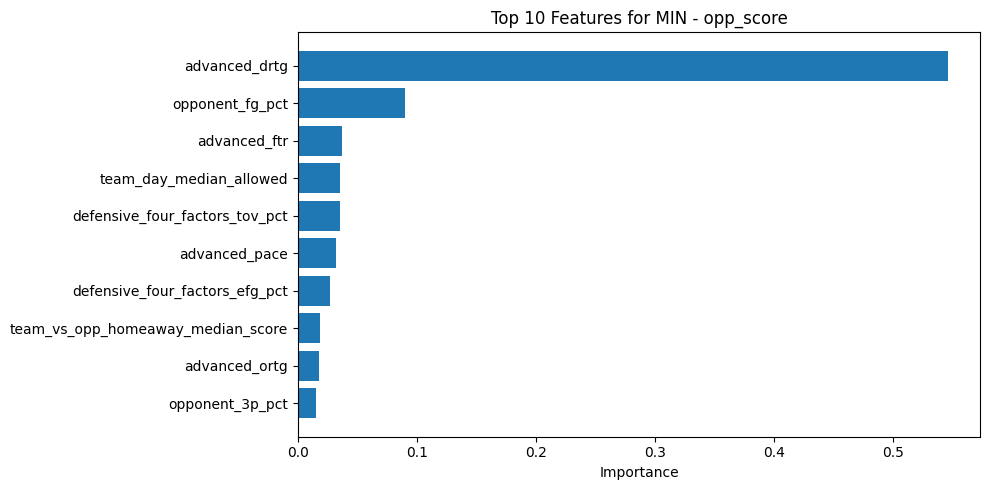

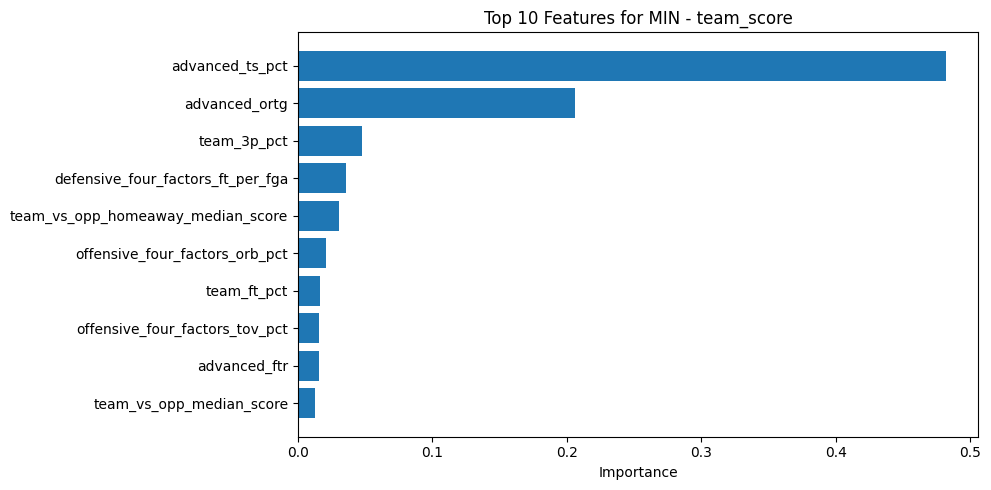

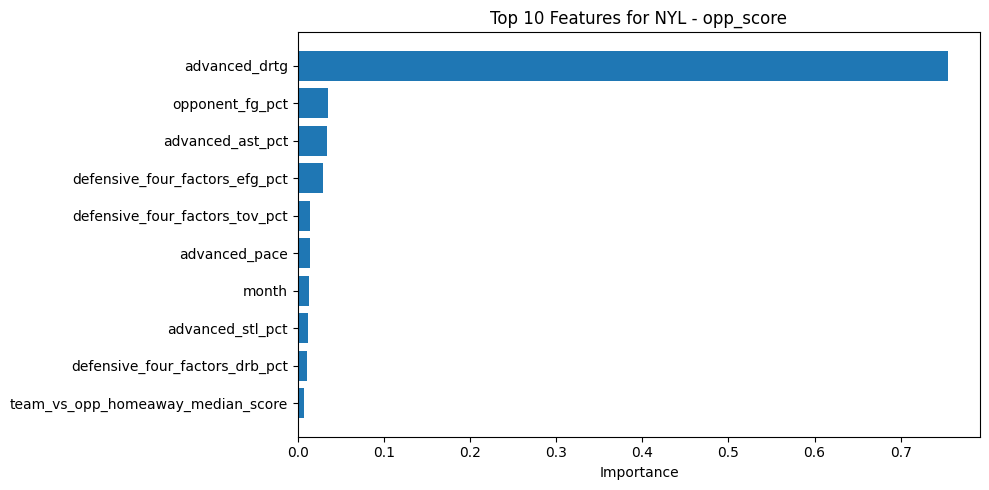

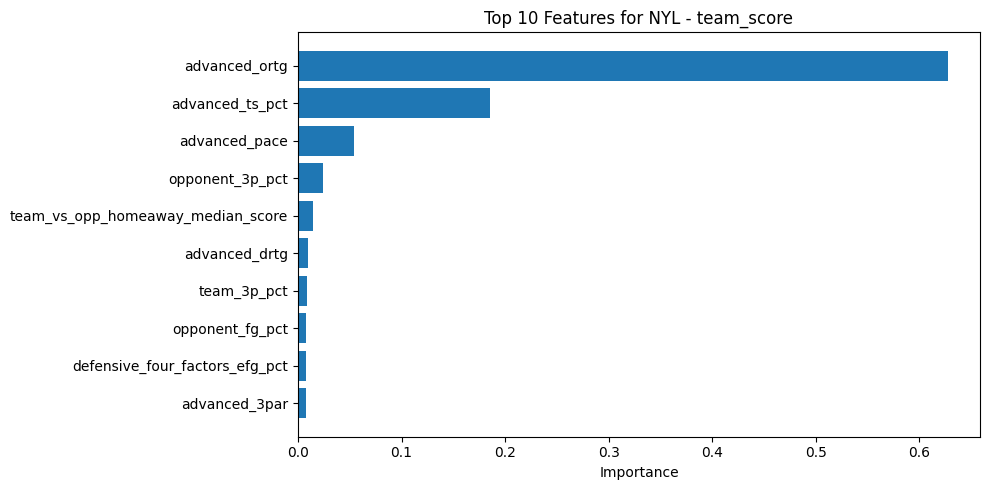

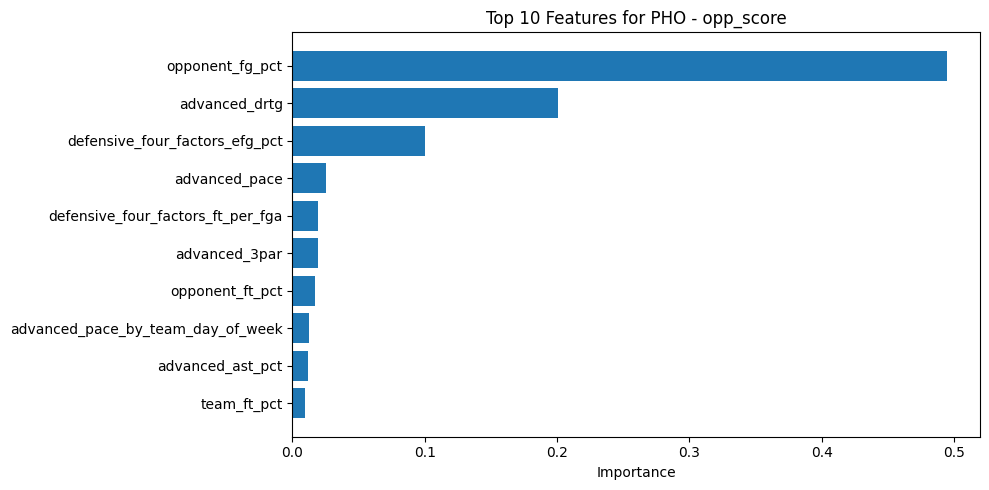

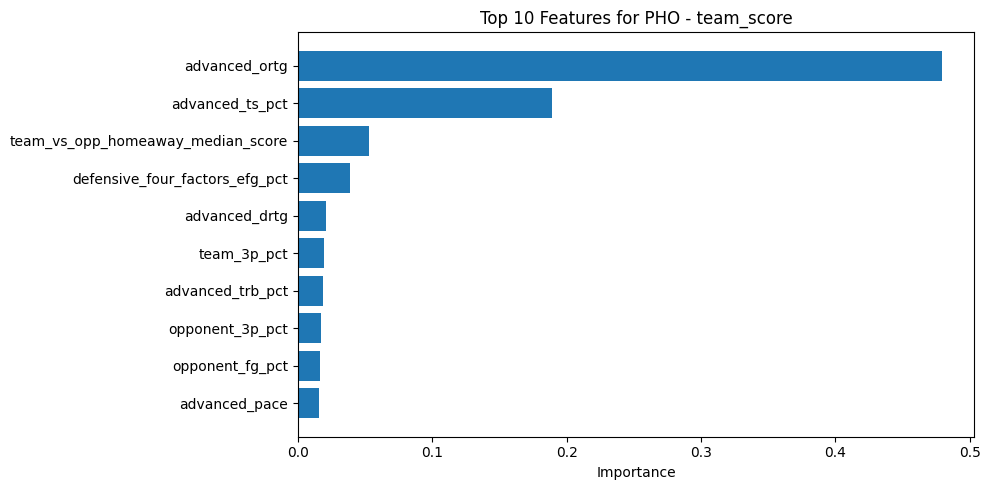

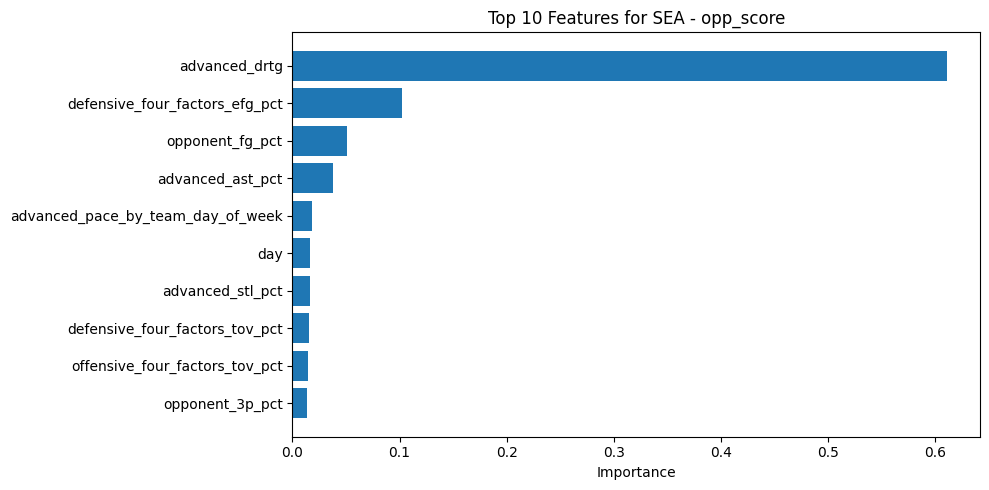

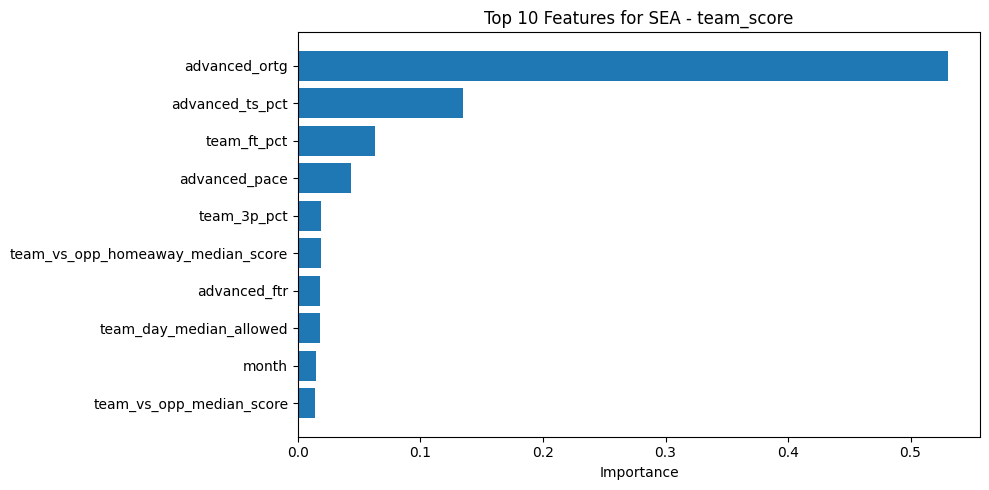

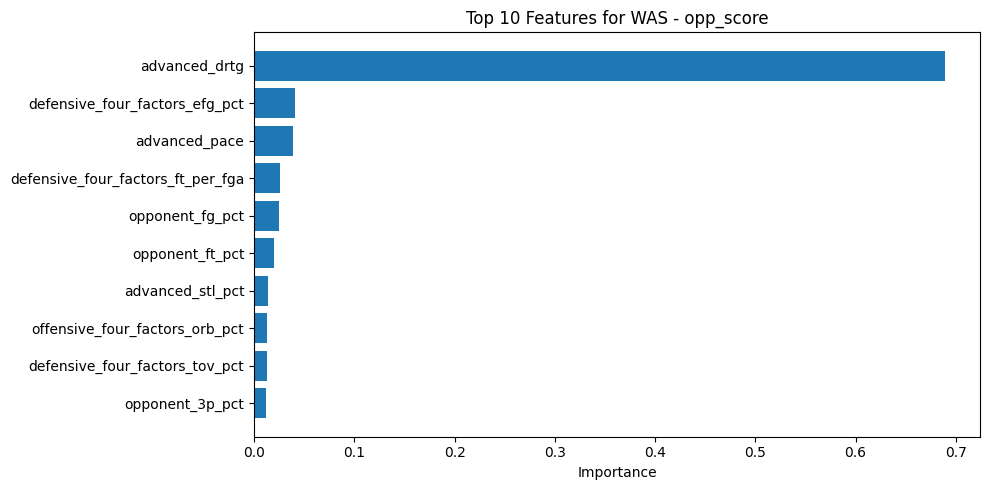

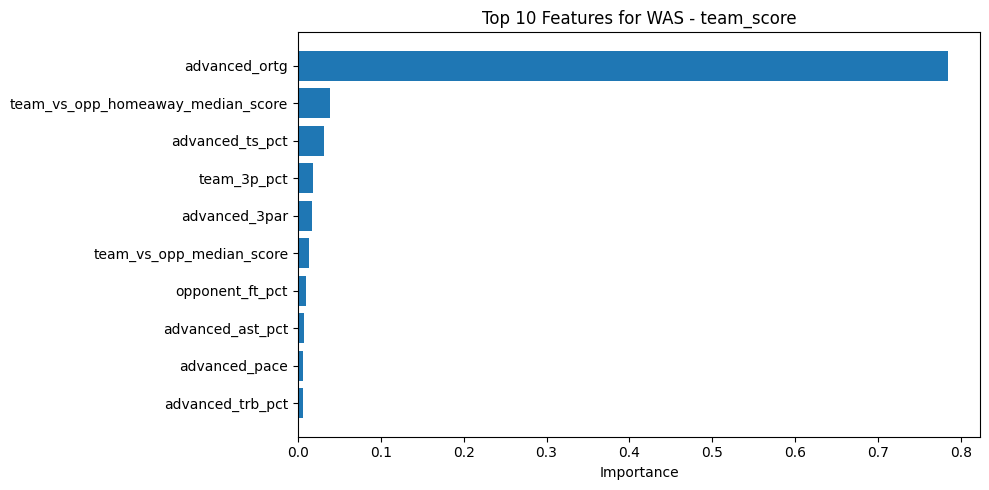

In [18]:
# Group by team + target and get top 10 features by importance
top_features = (
    importances_df.groupby(['Model', 'Target'])
    .apply(lambda group: group.sort_values('Importance', ascending=False).head(10))
    .reset_index(drop=True)
)

# Plot each team/target combo
for (model, target), group in top_features.groupby(['Model', 'Target']):
    plt.figure(figsize=(10, 5))
    plt.barh(group['Feature'], group['Importance'])
    plt.xlabel("Importance")
    plt.title(f"Top 10 Features for {model} - {target}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [21]:
# Filter to only player features (ending in "_played")
player_importances = importances_df[importances_df['Feature'].str.endswith('_played')]

# Group by player, average importance per target
avg_player_importance = (
    player_importances
    .groupby(['Feature', 'Target'])['Importance']
    .mean()
    .reset_index()
    .sort_values(by='Importance', ascending=False)
)

# Show top 20 overall
print(avg_player_importance.head(20))

Empty DataFrame
Columns: [Feature, Target, Importance]
Index: []


In [22]:
# extract player column names based on dtype and value patterns
potential_player_features = [
    col for col in df.columns
    if col not in ['team', 'opp', 'team_score', 'opp_score']  # exclude targets and IDs
    and df[col].nunique() <= 2  # likely binary
    and df[col].dtype in [int, float]
    and set(df[col].dropna().unique()).issubset({0, 1})  # must be 0 or 1
]

In [23]:
player_importances = importances_df[importances_df['Feature'].isin(potential_player_features)]

In [24]:
player_importances

,Model,Feature,Target,Importance
1684,PHO,Satou Sabally,team_score,0.000000
1674,PHO,Odyssey Sims,team_score,0.000000
1675,PHO,Odyssey Sims,opp_score,0.000000
1678,PHO,Rhyne Howard,team_score,0.000000
1679,PHO,Rhyne Howard,opp_score,0.000000
...,...,...,...,...
664,DAL,Satou Sabally,team_score,0.003573
1308,MIN,Kayla McBride,team_score,0.003747
846,IND,Temi Fagbenle,team_score,0.004940
1113,LVA,Chelsea Gray,opp_score,0.008565


In [25]:
# identify binary player columns
player_columns = [
    col for col in df.columns
    if col not in ['team', 'opp', 'team_score', 'opp_score']
    and df[col].nunique() <= 2
    and set(df[col].dropna().unique()).issubset({0, 1})
]

# drop player columns where sum == 40 (played every game)
cols_to_drop = [col for col in player_columns if df[col].sum() == 40]
df = df.drop(columns=cols_to_drop)

In [26]:
df.shape

(480, 70)

In [27]:
# save as CSV
df.to_csv("wnba_model_ready_with_top_off_def_players_v2.csv", index=False)

# download to local machine
from google.colab import files
files.download("wnba_model_ready_with_top_off_def_players_v2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
# Save model MAE summary
mae_summary.to_csv("wnba_model_summary_v2.csv", index=False)

In [37]:
# Save model predictions
predictions_df.to_csv("wnba_model_predictions_v2.csv", index=False)

In [38]:
# Save model importances
importances_df.to_csv("wnba_model_feature_importance_v2.csv", index=False)

In [39]:
# download all three CSVs
files.download("wnba_model_feature_importance_v2.csv")
files.download("wnba_model_predictions_v2.csv")
files.download("wnba_model_summary_v2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>